## **Funciones Básicas**

### **Colab**

Por lo general, en **Google Colab** están instaladas y configuradas la mayoría de dependencias necesarias para el procesamiento y análisis de imágenes. Sin embargo, para asegurar que las dependencias y sus versiones sean las correctas, se recomienda instalar [**OpenSlide**](https://openslide.org/api/python/) o [**Large Image**](https://github.com/girder/large_image). Ambas son librerías especializadas en abrir imágenes de gran resolución en formato piramidal, como son las imágenes de histopatología.

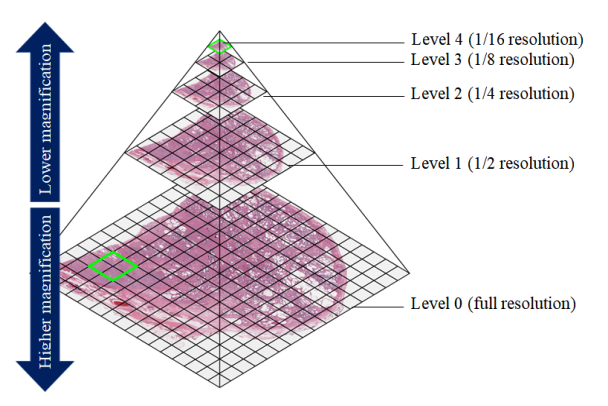

**Figura 1.** Imagen multi-resolución en formato piramidal. Recuperada de: [**Bag of Visual Words (BoVW) with Deep Features**](https://www.researchgate.net/publication/358795489_Bag_of_Visual_Words_BoVW_with_Deep_Features_--_Patch_Classification_Model_for_Limited_Dataset_of_Breast_Tumours)

In [ ]:
%%capture
!apt-get update
!apt-get install openslide-tools
!apt-get install python3-openslide

In [ ]:
%%capture
!pip install large-image[all] --find-links https://girder.github.io/large_image_wheels

### **Local**

En el equipo local es necesario tener instalado **python** para instalar OpenSlide o Large Image.

**PD:** Se recomienda usar una versión de python inferior a la última disponible por temas de compatibilidad. Versiones estables superiores a [**3.6**](https://www.python.org/downloads/release/python-368/) e inferiores a [**3.9**](https://www.python.org/downloads/release/python-384/) son buenas opciones.


```sh
$ pip install openslide-python
$ pip install large-image[all] --find-links https://girder.github.io/large_image_wheels
```

### **Dependencias básicas**

A continuación se incluyen algunas de las dependencias más usadas en el procesamiento de imágenes con python.

In [ ]:
# Dependencia para la administración de archivos y directorios
import os

# Dependencia principal de procesamiento matemático y científico
import numpy as np

# Dependencia para el análisis y manipulación de datos
import pandas as pd

# Dependencia para el procesamiento y visualización de imágenes (Pillow)
from PIL import Image

# Dependencia para el procesamiento y visualización de imágenes (OpenCV)
import cv2

# Dependencia para la visualización de datos estadísticos
from matplotlib import pyplot as plt
%matplotlib inline

# Dependencia para la visualización de datos estadísticos
import seaborn as sns

In [ ]:
# Dependencia para el procesamiento y visualización de imágenes multi-resolución en formato piramidal
from openslide import OpenSlide

# Dependencia para el procesamiento, visualización y análisis de imágenes médicas y geoespaciales
import large_image

### **Abrir una WSI (Whole Slide Image) con OpenSlide**

La documentación de [**OpenSlide**](https://openslide.org/api/python/) es escasa pero suficiente para tareas simples como abrir una imagen y extraer metadatos o parches simples.

In [ ]:
# Abrir la imagen
image = OpenSlide("Ruta de la imagen")

In [ ]:
# Cerrar la imagen y liberar recursos
image.close()

### **Extraer los metadatos básicos**

Por lo general, las imágenes tienen un conjunto de metadatos asociados. Los metadatos más importantes a tener en cuenta son la **magnificación** (*zoom o nivel de objetivo real del microscopio*) y la relación de **micras por pixel** **- MPP** (relación entre un pixel en pantalla y su valor real en micras **-μm**).

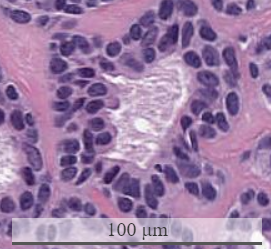

In [ ]:
# Generalmente identifica al fabricante del escaner (Aperio, Leica, ...)
format = OpenSlide.detect_format("Ruta de la imagen")

# Número de niveles en la imagen. 
# Los niveles están enumerados desde 0 (la más alta resolución) hasta level_count - 1 (la más baja resolución).
level_count = image.level_count

# Ancho y alto de la imagen en el nivel 0
# Retorna una tupla (width, height)
dimensions = image.dimensions

# Dimensiones de cada uno de los niveles de la imagen
# Retorna una lista de tuplas (width, height), una para cada nivel de la imagen.
level_dimensions = image.level_dimensions

# Factor de reducción de los niveles de la imagen
# Retorna una lista de factores de reducción para cada nivel de la imagen.
level_downsamples = image.level_downsamples

# Retorna todos los metadatos de la imagen.
properties = image.properties

# Busca y retorna la mayor magnificación de la imagen (e.g. 20x, 40x, ...)
magnification = properties[detect_format+'.AppMag']

# Busca y retorna la relación de micras por pixel de la imagen (e.g. 0.25, 0.50, ...)
mpp = properties[detect_format+'.MPP']

# Tamaño de la imagen en bytes
size = os.path.getsize("Ruta de la imagen")

### **Extraer las imágenes asociadas**

En algunos casos es importante extraer las imagenes asociadas que vienen comprimidas dentro de la estructura de la imagen. Por lo general, estas imagenes son el **thumbnail** (miniatura de la imagen), la imagen **macro** (la lámina completa de vidrio) y la **etiqueta** (la imagen del codigo de barras o QR con informacion de la muestra).

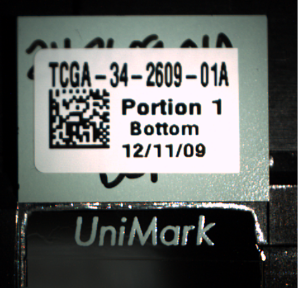

In [ ]:
# ["thumbnail, label, macro, ..."]
associated_images = image.associated_images

In [ ]:
# Retorna el ancho y alto del thumbnail de la imagen
width, height = associated_images['thumbnail'].size

# Extrae el thumbnail de la imagen con un ancho y alto definidos
get_thumbnail = image.get_thumbnail((width, height))

### **Abrir una imagen con una librería alternativa**

Algunas librerias usan **OpenSlide** como núcleo para el procesamiento pero integran nuevas funciones de alto nivel para facilitar tareas típicas (e.g. extraccion de parches). **Large Image** es una de ellas. Entre sus ventajas está la posibilidad de extraer parches con o sin **solapamiento** (overlaping), a diferentes **escalas** (magnificaciones del objetivo) y exportar en **diferentes formatos** (matrices numpy, imagenes jpeg o png, imágenes comprimidas en formato piramidal - **TIFF**).

In [ ]:
image = large_image.open("Ruta de la imagen")

### **Extraer parches**

In [ ]:
for tile_info in image.tileIterator(
    region=dict(left=y, top=x, width=width, height=height, units='base_pixels'), # Región de interés
    scale=dict(magnification=magnification), # Magnificación
    tile_size=dict(width=patch_width, height=patch_height), # Tamaño del parche
    tile_overlap=dict(x=0, y=0), # Solapamiento
    format=large_image.constants.TILE_FORMAT_NUMPY # Formato de salida
):

    # Para extraer o procesar un parche específico
    patch = tile_info['tile']
    width, height, _ = patch.shape

    # Transformar la matriz en un objeto de imagen y cambiar su formato de color
    tile = Image.fromarray(patch).convert('RGB')
    tile.save("Ruta y nombre de guardado")